In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

from casting.configuration import paths, columns, params
from casting.preprocessing import (
                                   drop_null, 
                                   split_by_dbscan,
                                   remove_outlier,
                                   save_scaler,
                                   save_label_encoding)
from casting.utils import load_data


from casting.trainner import train_xgboost, train_lightgbm, train_extra_trees, train_tabnet, train_FTT, FttDataloader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix


from torch.utils.data import DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cpu


In [2]:
data_origin = pd.read_csv(paths.origin_path, encoding = 'euc-kr')
data = data_origin[columns.use_columns]

# Preprocessing

### base

In [3]:
## null 값 제외
data = drop_null(data).reset_index(drop=True)
## 이상치 제거
data = remove_outlier(data)


if params.model_name == 'FTT':
    ## 스케일러 생성
    save_scaler(data, 
                columns.numeric_columns, 
                columns.target_column,
                paths.X_scaler_path,
                paths.y_scaler_path
                )
    ## 카테고리 컬럼 처리를 위한 라벨 인코딩
    save_label_encoding(data, columns.category_columns, paths.label_encoding_path)

    split_by_dbscan(data, 'casting/data/scaled_data/')
else :
    ## 데이터 분리
    split_by_dbscan(data, 'casting/data/processed_data/')

# Predictor

### load_data

In [4]:
train, valid, test = load_data(params.model_name)

### Modeling

In [5]:
## TODO : 모듈 형식으로 모델 GATEWAY 함수 구성
## TODO : AUTO ML 넣어서 제일 좋은 성능을 Select하는 형식

if params.model_name == 'LGBM' :
    model = train_lightgbm(train, valid)
elif params.model_name == 'XGB' :
    model = train_xgboost(train, valid)
elif params.model_name == 'EXT' :
    model = train_extra_trees(train, valid)
elif params.model_name == 'TABNET' :
    model = train_tabnet(train, valid)
## GPU 환경 필수
elif params.model_name == 'FTT' :
    model = train_FTT(train, valid)

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Number of positive: 2586, number of negative: 59825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2397
[LightGBM] [Info] Number of data points in the train set: 62411, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041435 -> initscore=-3.141311
[LightGBM] [Info] Start training from score -3.141311


### inference

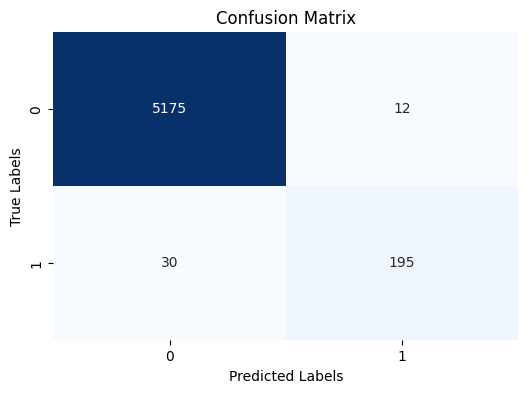

F1 Score: 0.9028
accuracy_score: 0.9922
precision_score: 0.9420
recall_score: 0.8667


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# 혼동 행렬 계산

## FTT 모델일때 inference
if params.model_name == 'FTT' :
    test_data = FttDataloader(test)
    test_loader = DataLoader(test_data, batch_size=len(test), shuffle=False)

    model.to(device)
    model.eval()
    all_pred = []
    all_y = []
    x_samples = []
    with torch.no_grad():
        cul_loss = 0  # SE
        count = 0
        for batch, (x_categ, x_numer, y) in enumerate(test_loader):
            x_categ, x_numer, y = x_categ.to(device), x_numer.to(device), y.to(device)
            # 예측 오류 계산
            pred = model(x_categ, x_numer)
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            all_pred.extend(pred)
            all_y.extend(y)

    all_pred = np.array(all_pred)
    all_y = np.array(all_y)

    y_test = pd.DataFrame(np.array(all_y)) 
    y_pred = pd.DataFrame(np.array(all_pred)).round(1).astype(int)
## 그외 모델일때
else :

    X_test, y_test = test[columns.input_columns], test[columns.target_column]
    

    y_pred = model.predict(X_test.values)
    test_cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 계산
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 점수 계산
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

acc = accuracy_score(y_test, y_pred)
print(f'accuracy_score: {acc:.4f}')

ps = precision_score(y_test, y_pred)
print(f'precision_score: {ps:.4f}')

rs = recall_score(y_test, y_pred)
print(f'recall_score: {rs:.4f}')


# Postprocessing

## 유민님 작업 공간